# Ventilator Pressure Prediction

### Author: Kepa Oiartzun Gonzalez
### Date: 07/10/2021

In [ ]:
# Importar archivos desde drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from time import time

%matplotlib inline
sns.set(style="darkgrid")

# Data Import & EDA

In [ ]:
# Import data from drive

train = pd.read_csv('/content/drive/MyDrive/DS/Ventilator Pressure Prediction/train.csv')
train

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


In [ ]:
# # Import data

# train = pd.read_csv('train.csv')
# train

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


### Exploratory Data Analysis

In [ ]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id         6036000 non-null  int64  
 1   breath_id  6036000 non-null  int64  
 2   R          6036000 non-null  int64  
 3   C          6036000 non-null  int64  
 4   time_step  6036000 non-null  float64
 5   u_in       6036000 non-null  float64
 6   u_out      6036000 non-null  int64  
 7   pressure   6036000 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [ ]:
# Initial recognition using sweetviz

import sweetviz as sv

analysis = sv.analyze(train)
analysis.show_html('sv_train_initial_recognition.html')

                                             |                                             | [  0%]   00:00 ->…

Report sv_train_initial_recognition.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
train[['R', 'C', 'time_step', 'u_in', 'u_out', 'pressure']].describe()

,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


Text(0.5, 1.0, 'Correlation Heatmap')

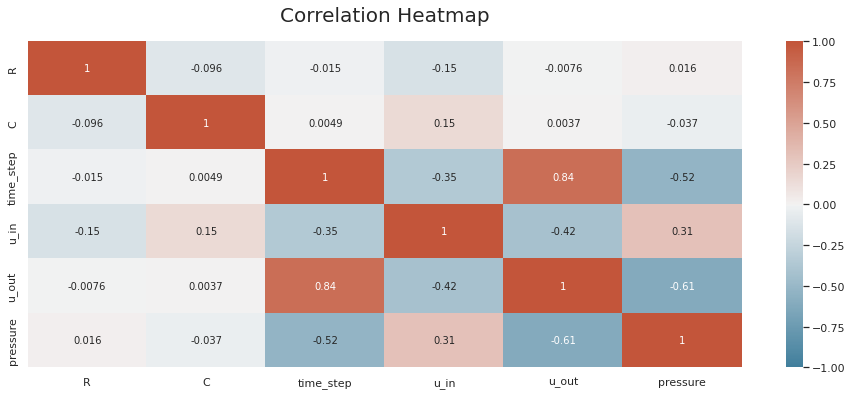

In [ ]:
# Checking correlation 

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train[['R', 'C', 'time_step', 'u_in', 'u_out', 'pressure']].corr() , vmin=-1, vmax=1, annot=True, cmap=cmap) # We will not plot the id variables in the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=20) # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.

We extract the following information:

- id: as expected, it is an identifier with all distinct values.
- breath_id has 75450 distinct values. It seems like it will be interesting to modelize each breath like a sequence.
- The variable R takes 3 distinct values: 50 (40%), 5 (33%), 20 (27%).
- The variable C takes 3 distinct values: 10 (37%), 50 (33%), 20 (30%).
- time_step: represents the time step in each breath.
- u_in: the variable takes continuous values from 0 to 100, and it's very skewed to de left.
- u_out is a binary variable with 62% of 1 and 38% of 0.
- pressure is the target variable, and it seems to take a pseudo normal distribution, skewed to the left.
- u_out seems to be highly correlated with time_step.
- u_out seems to be correlated with the target variable pressure.
- There are not null or duplicated values in the table, and the variables are correctly encoded, so there is not need for data cleaning.

#### u_out variable

We have seen that the variable u_out is correlated with with the variables time_step and pressure, so we will se how those variables interact with each other.

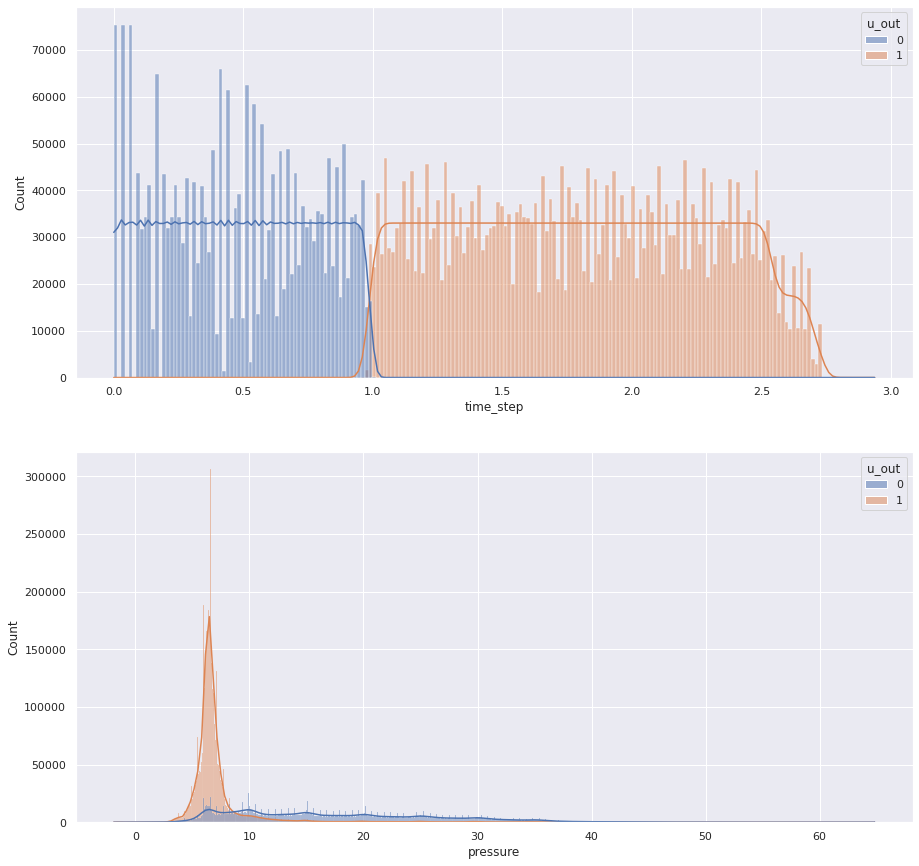

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
sns.histplot(train, x="time_step", hue="u_out", kde=True, ax=ax1)
sns.histplot(train, x="pressure", hue="u_out", kde=True, ax=ax2)
plt.show()

We can clearly see that when time_step is lower than 1 the variable u_out takes the value 0, and when time_step is higher than 1, the variable u_out takes the value 1.<br>
When the variable u_out is 1, the variable pressure uses to take lower values than 10, unlike when u_out is 0 and the pressure values are more equally distributed. <br>
This explais that the variables pressure and time_step have some correlation too.

# Modelling

### Feature engineering



#### Treatment of the target variable

Before modeling we will standarize the target variable.

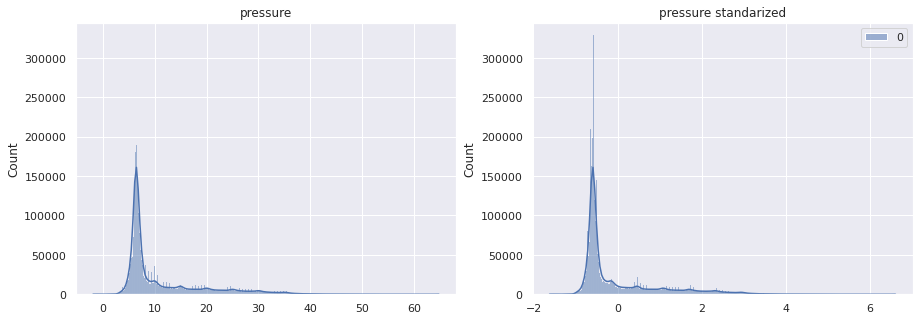

In [ ]:
# Visualize the standarized target variable

from sklearn.preprocessing import StandardScaler

stscaler = StandardScaler()
pressure_standarized = stscaler.fit_transform(np.array(train.pressure).reshape(-1, 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(np.array(train.pressure), kde=True, ax=ax1)
sns.histplot(pressure_standarized, kde=True, ax=ax2)
ax1.set_title("pressure")
ax2.set_title("pressure standarized")
plt.show()

In [ ]:
# The standarized target variable seems to improve the distribution, so we will save it

from sklearn.preprocessing import StandardScaler

stscaler = StandardScaler()
pressure_standarized = stscaler.fit_transform(np.array(train.pressure).reshape(-1, 1))

train['pressure_standarized'] = pressure_standarized

### Performance metrics function

In [ ]:
def performance_metrics(values, predictions, data='Validation', all_metrics=True):
    
    from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, r2_score
    
    values = np.array(values)
    predictions = np.array(predictions)
    
    # Title
    print('\nMetrics in the ', data, ' set:\n')
    
    # Regression metrics
    print('Mean squared error: ', mean_squared_error(values, predictions))
    print('Mean absolute error: ', mean_absolute_error(values, predictions))
    
    if all_metrics:
        print('R2 score: ', r2_score(values, predictions))
        print('Max error: ', max_error(values, predictions))
        print('Explained variance score: ', explained_variance_score(values, predictions))
    
        # Model quality
        residuals = values - predictions
        scatter_df = pd.DataFrame(np.concatenate([predictions.reshape(-1,1), residuals.reshape(-1,1)], axis=1), columns=['y_pred', 'residuals'])
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        sns.scatterplot(x='y_pred', y='residuals', data=scatter_df, ax=ax2)
        sns.histplot(residuals, kde=True, ax=ax1)
        ax1.set_title("Residuals distribution")
        ax2.set_title("Residuals variance")
        plt.show()

### Vif function

In [ ]:
def vif(df):
    from sklearn.linear_model import LinearRegression
    
    features = list(df.columns)
    x_features = features
    
    for feature in x_features:
        y = df[feature]
        x = df[x_features].drop(feature, axis=1)
        model = LinearRegression()
        model.fit(x,y)
        vif = 1 / (1 - model.score(x, y))
        print('The vif of the variable ', feature, ' is: ', vif)

## First tentative models

Firstly we will try some simple ML models like Linear Regression, Decision Tree, Ensemble Models and so on.<br>
For this models we will not use the variables breath_id and step, so, we will asume that the variable time_step represents that sequence component.

#### Preprocessing

In [ ]:
# Separating X and y

X = train.drop(['pressure', 'id', 'breath_id', 'pressure_standarized'], axis=1)
y = train['pressure_standarized']

# Data scaling: MinMax scaler

from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Separating train, validation and test splits

from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, random_state = 42, test_size = 0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state = 42, test_size = 0.2)

X_train.head()

,R,C,time_step,u_in,u_out
803549,0.0,0.00,0.317790,0.000000,0.0
2529077,0.0,1.00,0.428857,0.000000,1.0
5875043,1.0,0.00,0.035258,0.000000,0.0
2468541,1.0,0.00,0.717635,0.047725,1.0
1755478,0.0,0.25,0.412287,0.000000,1.0


#### Checking vifs

In [ ]:
vif(X_train)

The vif of the variable  R  is:  1.0339671680195146
The vif of the variable  C  is:  1.0342078770443333
The vif of the variable  time_step  is:  3.3829998115532
The vif of the variable  u_in  is:  1.2760917065447341
The vif of the variable  u_out  is:  3.5952471774041386


The vif values are not dangerous.

#### Model 1: Linear Regression


Metrics in the  Training  set:

Mean squared error:  0.6169390766664613
Mean absolute error:  0.4856193322736404

Metrics in the  Validation  set:

Mean squared error:  0.6188382460614366
Mean absolute error:  0.4862060201309457
R2 score:  0.3817969532446013
Max error:  5.7852100639633965
Explained variance score:  0.38179695344718134


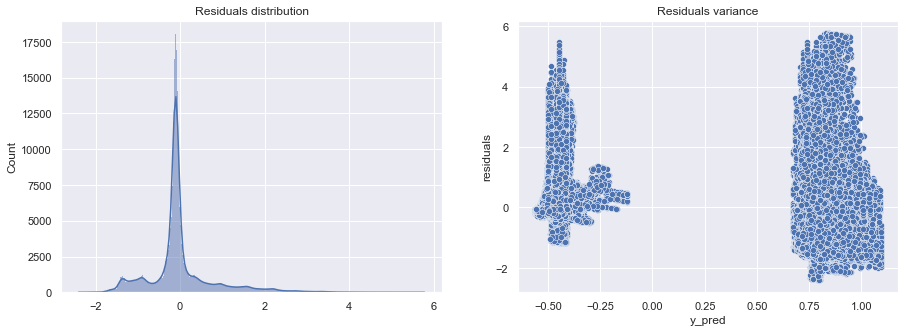

The cross validation scores with mean squared error have been:  [0.61546575 0.61917031 0.61770662 0.61746242 0.6168438 ]
The mean of cross validation scores with mean squared error have been:  0.6173297798036529
The standard deviation of cross validation scores with mean squared error have been:  0.0012048186368848867
The training time of the model and the cross validation has been:  3.7116007804870605  seconds.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

t1 = time()
model1 = LinearRegression().fit(X_train, y_train)

cross_val_model_1 = -cross_val_score(model1, X=X_train_val, y=y_train_val, scoring='neg_mean_squared_error', cv=5)
t2 = time()

performance_metrics(y_train, model1.predict(X_train), data='Training', all_metrics=False)
performance_metrics(y_val, model1.predict(X_val))

print('The cross validation scores with mean squared error have been: ', cross_val_model_1)
print('The mean of cross validation scores with mean squared error have been: ', cross_val_model_1.mean())
print('The standard deviation of cross validation scores with mean squared error have been: ', cross_val_model_1.std())
print('The training time of the model and the cross validation has been: ', t2-t1, ' seconds.')

#### Model 2: Decision Tree


Metrics in the  Training  set:

Mean squared error:  0.017992078652555425
Mean absolute error:  0.01990880782353229

Metrics in the  Validation  set:

Mean squared error:  0.3914844019250451
Mean absolute error:  0.29683433466591824
R2 score:  0.6089174326771472
Max error:  6.553683089483004
Explained variance score:  0.6089182896681256


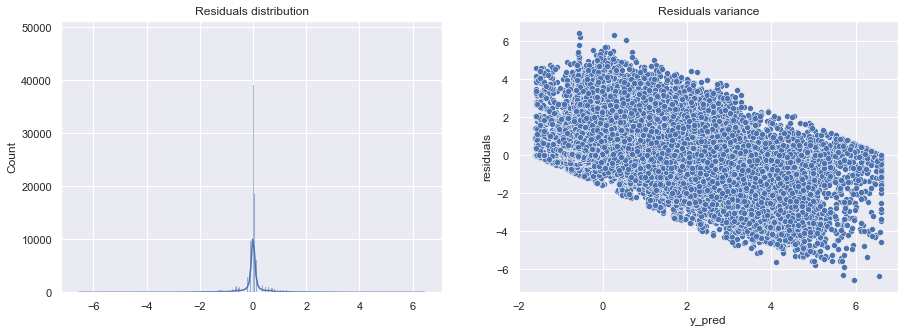

The cross validation scores with mean squared error have been:  [0.39143362 0.39428658 0.39051472 0.38857758 0.39125624]
The mean of cross validation scores with mean squared error have been:  0.39121374895154604
The standard deviation of cross validation scores with mean squared error have been:  0.0018401326275608776
The training time of the model and the cross validation has been:  137.20027017593384  seconds.


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

t1 = time()
model2 = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

cross_val_model_2 = -cross_val_score(model2, X=X_train_val, y=y_train_val, scoring='neg_mean_squared_error', cv=5)
t2 = time()

performance_metrics(y_train, model2.predict(X_train), data='Training', all_metrics=False)
performance_metrics(y_val, model2.predict(X_val))

print('The cross validation scores with mean squared error have been: ', cross_val_model_2)
print('The mean of cross validation scores with mean squared error have been: ', cross_val_model_2.mean())
print('The standard deviation of cross validation scores with mean squared error have been: ', cross_val_model_2.std())
print('The training time of the model and the cross validation has been: ', t2-t1, ' seconds.')

#### Model 3: Another Decision Tree

The error in the training set of the second model is very small compared with the error in the validation set, and we suspect that it can be overfitting. We well train another tree mith a maximum depth to see if the metrics improve.


Metrics in the  Training  set:

Mean squared error:  0.2165899836511976
Mean absolute error:  0.23190175500703475

Metrics in the  Validation  set:

Mean squared error:  0.2288728328187233
Mean absolute error:  0.23914425232654674
R2 score:  0.7713620910333537
Max error:  6.723810114127319
Explained variance score:  0.7713624187272063


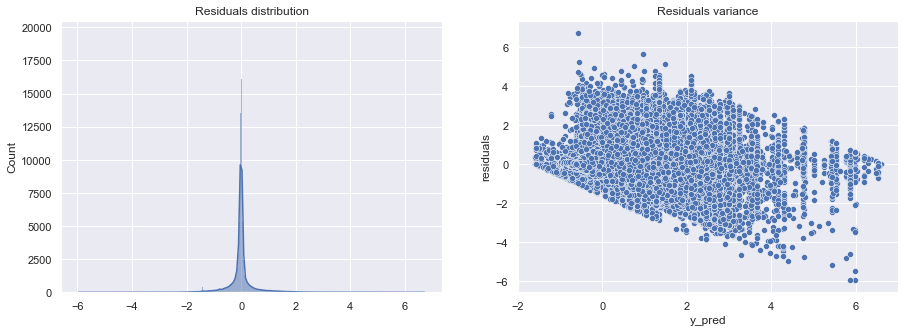

The cross validation scores with mean squared error have been:  [0.22911505 0.2297803  0.22873502 0.22827212 0.22831092]
The mean of cross validation scores with mean squared error have been:  0.2288426835185513
The standard deviation of cross validation scores with mean squared error have been:  0.0005609289453797217
The training time of the model and the cross validation has been:  84.59766578674316  seconds.


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

t1 = time()
model3 = DecisionTreeRegressor(random_state=42, max_depth=15).fit(X_train, y_train)

cross_val_model_3 = -cross_val_score(model3, X=X_train_val, y=y_train_val, scoring='neg_mean_squared_error', cv=5)
t2 = time()

performance_metrics(y_train, model3.predict(X_train), data='Training', all_metrics=False)
performance_metrics(y_val, model3.predict(X_val))

print('The cross validation scores with mean squared error have been: ', cross_val_model_3)
print('The mean of cross validation scores with mean squared error have been: ', cross_val_model_3.mean())
print('The standard deviation of cross validation scores with mean squared error have been: ', cross_val_model_3.std())
print('The training time of the model and the cross validation has been: ', t2-t1, ' seconds.')

#### Model 4: Random Forest


Metrics in the  Training  set:

Mean squared error:  0.21001825332161314
Mean absolute error:  0.22885799547096472

Metrics in the  Validation  set:

Mean squared error:  0.22118055898212463
Mean absolute error:  0.23537873252316488
R2 score:  0.7790464692251148
Max error:  5.820413683285315
Explained variance score:  0.7790468287260006


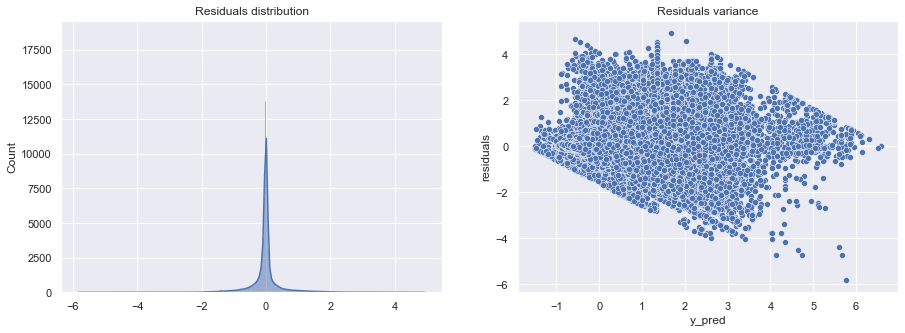

The cross validation scores with mean squared error have been:  [0.22137341 0.22159309 0.22023759 0.21975212 0.21981656]
The mean of cross validation scores with mean squared error have been:  0.22055455321781645
The standard deviation of cross validation scores with mean squared error have been:  0.000779497251302315
The training time of the model and the cross validation has been:  1491.4360206127167  seconds.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

t1 = time()
model4 = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=25).fit(X_train, y_train)

cross_val_model_4 = -cross_val_score(model4, X=X_train_val, y=y_train_val, scoring='neg_mean_squared_error', cv=5)
t2 = time()

performance_metrics(y_train, model4.predict(X_train), data='Training', all_metrics=False)
performance_metrics(y_val, model4.predict(X_val))

print('The cross validation scores with mean squared error have been: ', cross_val_model_4)
print('The mean of cross validation scores with mean squared error have been: ', cross_val_model_4.mean())
print('The standard deviation of cross validation scores with mean squared error have been: ', cross_val_model_4.std())
print('The training time of the model and the cross validation has been: ', t2-t1, ' seconds.')

#### Model 5: SVR

In [ ]:
# from sklearn.svm import SVR
# from sklearn.model_selection import cross_val_score

# t1 = time()
# model5 = SVR().fit(X_train, y_train)

# cross_val_model_5 = -cross_val_score(model5, X=X_train_val, y=y_train_val, scoring='neg_mean_squared_error', cv=5)
# t2 = time()

# performance_metrics(y_train, model5.predict(X_train), data='Training', all_metrics=False)
# performance_metrics(y_val, model5.predict(X_val))

# print('The cross validation scores with mean squared error have been: ', cross_val_model_5)
# print('The mean of cross validation scores with mean squared error have been: ', cross_val_model_5.mean())
# print('The standard deviation of cross validation scores with mean squared error have been: ', cross_val_model_5.std())
# print('The training time of the model and the cross validation has been: ', t2-t1, ' seconds.')

#### Model 5: XGBoost

[08:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:40:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:45:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Metrics in the  Training  set:

Mean squared error:  0.20096892784480327
Mean absolute error:  0.2487712531850418

Metrics in the  Validation  set:

Mean squared error:  0.21788858488565754
Mean absolute error:  0.25801442431762006
R2 sc

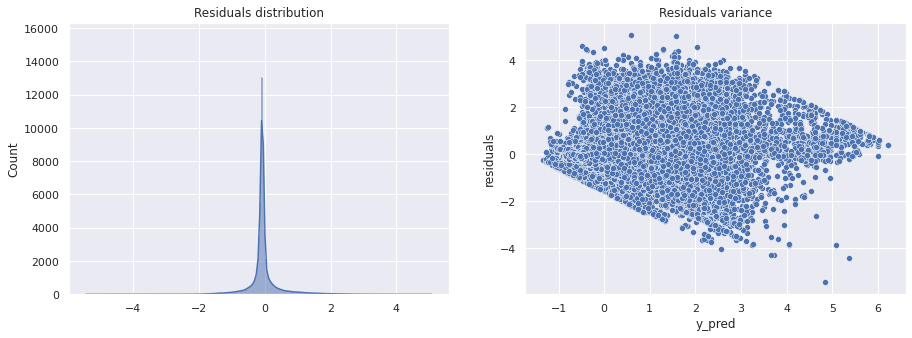

The cross validation scores with mean squared error have been:  [0.21648036 0.21815973 0.21665263 0.21550672 0.21626882]
The mean of cross validation scores with mean squared error have been:  0.21661365130232166
The standard deviation of cross validation scores with mean squared error have been:  0.0008664708547691827
The training time of the model and the cross validation has been:  1785.2577567100525  seconds.


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

t1 = time()
model6 = XGBRegressor(random_state = 42, max_depth=15, n_estimators=25).fit(X_train, y_train)

cross_val_model_6 = -cross_val_score(model6, X=X_train_val, y=y_train_val, scoring='neg_mean_squared_error', cv=5)
t2 = time()

performance_metrics(y_train, model6.predict(X_train), data='Training', all_metrics=False)
performance_metrics(y_val, model6.predict(X_val))

print('The cross validation scores with mean squared error have been: ', cross_val_model_6)
print('The mean of cross validation scores with mean squared error have been: ', cross_val_model_6.mean())
print('The standard deviation of cross validation scores with mean squared error have been: ', cross_val_model_6.std())
print('The training time of the model and the cross validation has been: ', t2-t1, ' seconds.')

#### Model 7: Light GBM


Metrics in the  Training  set:

Mean squared error:  0.25032276724182384
Mean absolute error:  0.26065888149436534

Metrics in the  Validation  set:

Mean squared error:  0.2518839953309751
Mean absolute error:  0.26169445326570806
R2 score:  0.748374548060702
Max error:  5.579449508734617
Explained variance score:  0.7483745611401403


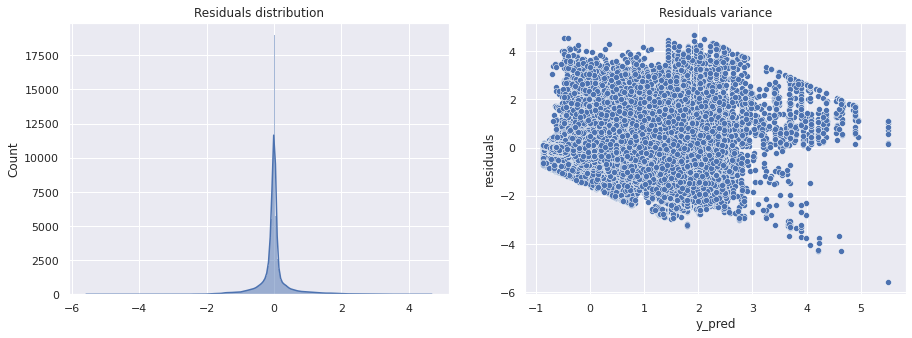

The cross validation scores with mean squared error have been:  [0.25080501 0.25267335 0.25000051 0.25018734 0.24940366]
The mean of cross validation scores with mean squared error have been:  0.25061397349581205
The standard deviation of cross validation scores with mean squared error have been:  0.0011225645812868647
The training time of the model and the cross validation has been:  153.0465109348297  seconds.


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

t1 = time()
model7 = LGBMRegressor(random_state = 42).fit(X_train, y_train)

cross_val_model_7 = -cross_val_score(model7, X=X_train_val, y=y_train_val, scoring='neg_mean_squared_error', cv=5)
t2 = time()

performance_metrics(y_train, model7.predict(X_train), data='Training', all_metrics=False)
performance_metrics(y_val, model7.predict(X_val))

print('The cross validation scores with mean squared error have been: ', cross_val_model_7)
print('The mean of cross validation scores with mean squared error have been: ', cross_val_model_7.mean())
print('The standard deviation of cross validation scores with mean squared error have been: ', cross_val_model_7.std())
print('The training time of the model and the cross validation has been: ', t2-t1, ' seconds.')

## Tentative Deep Learning Models

Next we will try some recurrent and convolutional neural networks, and see if these models improve the performance of the last ones.

#### Preprocessing

In order to process each breath like a sequence, we will reshape the data to get an apropiate input for the tensorflow models.

In [ ]:
# Separating X and y

X = train.drop(['pressure', 'id', 'breath_id', 'pressure_standarized'], axis=1)
y = train['pressure_standarized']

# Data scaling: MinMax scaler

from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Reshaping: The train data is perfectly ordered by breath_id and time_step, and there are 80 rows per breath, so we only need to use the reshape function

X = X_scaled.values.reshape((75450,80,5))
y = y.values.reshape((75450,80,1))

# Separating train, validation and test splits

from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state = 42, test_size = 0.2)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_val.shape: ', X_val.shape)
print('y_val.shape: ', y_val.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (48288, 80, 5)
y_train.shape:  (48288, 80, 1)
X_val.shape:  (12072, 80, 5)
y_val.shape:  (12072, 80, 1)
X_test.shape:  (15090, 80, 5)
y_test.shape:  (15090, 80, 1)


#### Model 8: Simple RNN returning sequences

Firsltly we are going to try diferent simple models with diferent RNN types, to have an intuition of witch one fits better with the data. The output of these models are going to be the sequences returned directly form the rnn.

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_27 (SimpleRNN)    (None, 80, 24)            720       
_________________________________________________________________
simple_rnn_28 (SimpleRNN)    (None, 80, 1)             26        
Total params: 746
Trainable params: 746
Non-trainable params: 0
_________________________________________________________________
None

Metrics in the  Training  set:

Mean squared error:  0.07597946170490107
Mean absolute error:  0.1710372698584787

Metrics in the  Validation  set:

Mean squared error:  0.07658797837365179
Mean absolute error:  0.17168605951091886
R2 score:  0.9239972449990271
Max error:  3.7141752344173273
Explained variance score:  0.9240137300557832


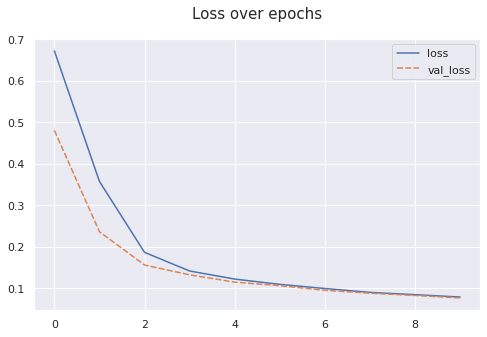

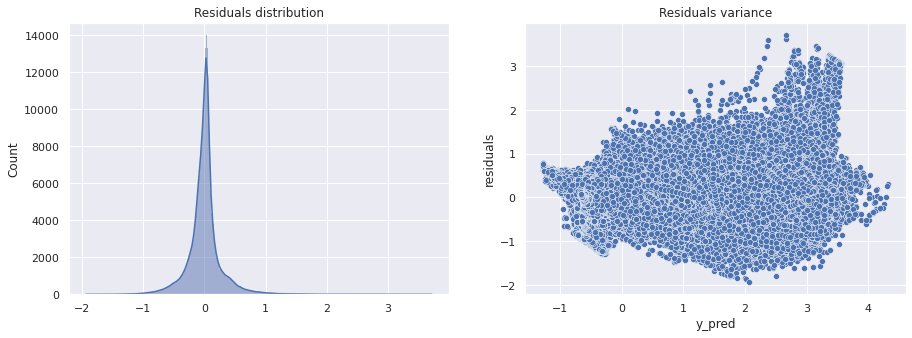

The training time of the model has been:  31.362369537353516  seconds.


In [ ]:
# Model 8.1

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=3, monitor='loss')

t1 = time()
model8_1 = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(24, return_sequences=True, input_shape=(80,5)),
  tf.keras.layers.SimpleRNN(1, return_sequences=True, activation='linear')
])
model8_1.compile(loss='mean_squared_error', optimizer='adam')
print(model8_1.summary())
history = model8_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, batch_size = 512, verbose=0, callbacks=[callback])
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

performance_metrics(y_train.flatten(), model8_1.predict(X_train).flatten(), data='Training', all_metrics=False)
performance_metrics(y_val.flatten(), model8_1.predict(X_val).flatten())

print('The training time of the model has been: ', t2-t1, ' seconds.') 

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 80, 24)            2880      
_________________________________________________________________
lstm_9 (LSTM)                (None, 80, 1)             104       
Total params: 2,984
Trainable params: 2,984
Non-trainable params: 0
_________________________________________________________________
None

Metrics in the  Training  set:

Mean squared error:  0.07971691423453744
Mean absolute error:  0.17196103191470483

Metrics in the  Validation  set:

Mean squared error:  0.08002824672736382
Mean absolute error:  0.17247782414400975
R2 score:  0.9205832643929699
Max error:  3.208650080665434
Explained variance score:  0.9210664186188953


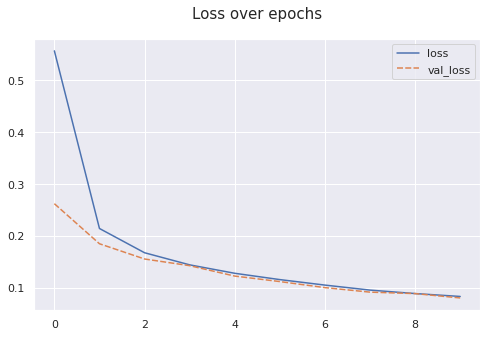

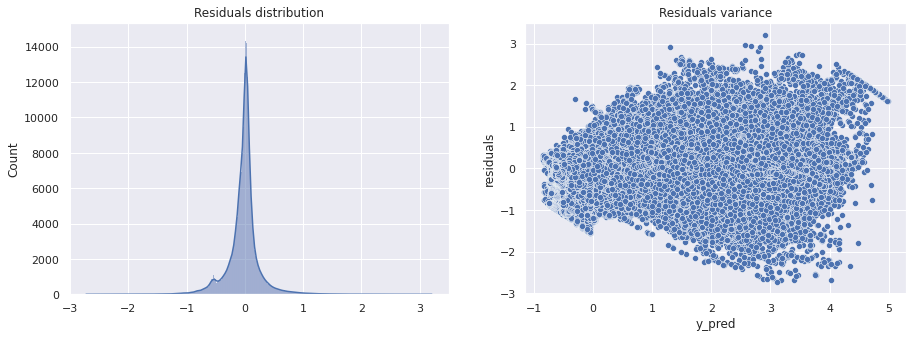

The training time of the model has been:  82.41079235076904  seconds.


In [ ]:
# Model 8.2 Let's see if LSTM layers improve the results

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=3, monitor='loss')

t1 = time()
model8_2 = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(24, return_sequences=True, input_shape=(80,5)),
  tf.keras.layers.LSTM(1, return_sequences=True, activation='linear')
])
model8_2.compile(loss='mean_squared_error', optimizer='adam')
print(model8_2.summary())
history = model8_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, batch_size = 512, verbose=0, callbacks=[callback])
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

performance_metrics(y_train.flatten(), model8_2.predict(X_train).flatten(), data='Training', all_metrics=False)
performance_metrics(y_val.flatten(), model8_2.predict(X_val).flatten())

print('The training time of the model has been: ', t2-t1, ' seconds.') 

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 80, 48)            5760      
_________________________________________________________________
lstm_11 (LSTM)               (None, 80, 1)             200       
Total params: 5,960
Trainable params: 5,960
Non-trainable params: 0
_________________________________________________________________
None

Metrics in the  Training  set:

Mean squared error:  0.07597587840086502
Mean absolute error:  0.15687713374125514

Metrics in the  Validation  set:

Mean squared error:  0.07651297310661226
Mean absolute error:  0.15747579126756134
R2 score:  0.9240716771364936
Max error:  3.3938792902693056
Explained variance score:  0.9249857034590393


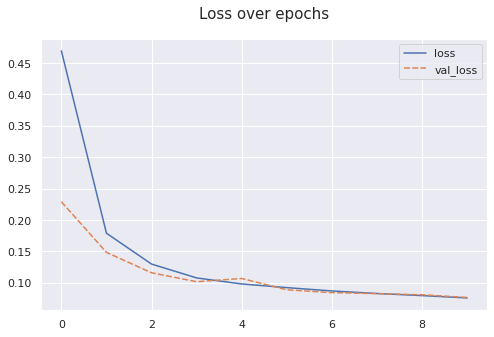

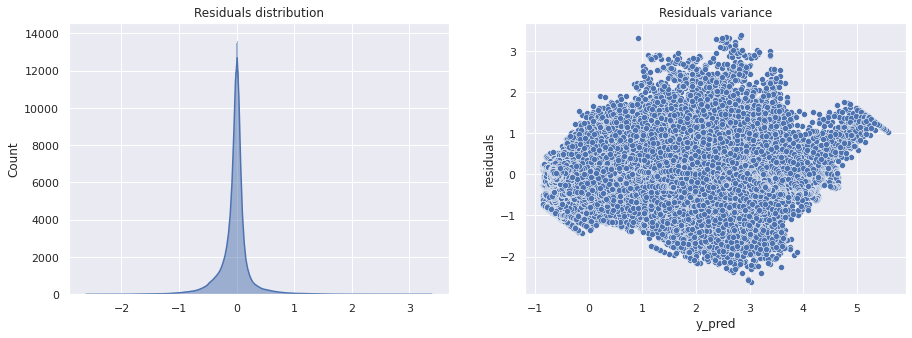

The training time of the model has been:  135.27634072303772  seconds.


In [ ]:
# Model 8.3: Let's se if bidirectional LSTMs improve the result

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=3, monitor='loss')

t1 = time()
model8_3 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, return_sequences=True), input_shape=(80,5)),
  tf.keras.layers.LSTM(1, return_sequences=True, activation='linear')
])
model8_3.compile(loss='mean_squared_error', optimizer='adam')
print(model8_3.summary())
history = model8_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, batch_size = 512, verbose=0, callbacks=[callback])
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

performance_metrics(y_train.flatten(), model8_3.predict(X_train).flatten(), data='Training', all_metrics=False)
performance_metrics(y_val.flatten(), model8_3.predict(X_val).flatten())

print('The training time of the model has been: ', t2-t1, ' seconds.') 

As a conclusion, we will take in count the SimpleRNN and the Bidirectional LSTM architectures. We will not take in count LSTM architecture because SimpleRNN improves its performance and it is simpler.

#### Model 9: RNN + dense layers

These models are going to be similar to the last ones, with the diference in the output: the output layer will be a dense layer with a neuron unit per sequence step.

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_35 (SimpleRNN)    (None, 24)                720       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               3200      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 80)                10320     
Total params: 14,240
Trainable params: 14,240
Non-trainable params: 0
_________________________________________________________________
None

Metrics in the  Training  set:

Mean squared error:  0.08177485651276838
Mean absolute error:  0.16491377671915547

Metrics in the  Validation  set:

Mean squared error:  0.08355571583421731
Mean absolute error:  0.16650674629308596
R2 score

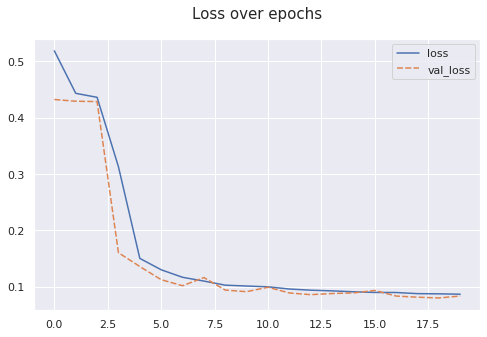

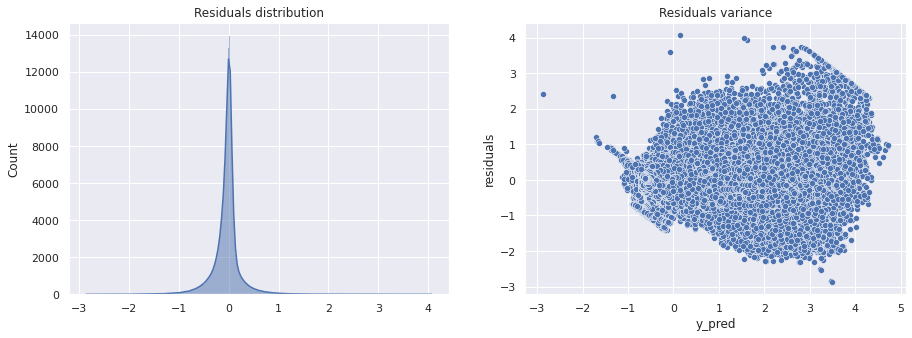

The training time of the model has been:  39.97350335121155  seconds.


In [ ]:
# Model 9.1

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=3, monitor='loss')

t1 = time()
model9_1 = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(24, input_shape=(80,5)),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(80)
])
model9_1.compile(loss='mean_squared_error', optimizer='adam')
print(model9_1.summary())
history = model9_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 20, batch_size = 512, verbose=0, callbacks=[callback]) # We encrease epochs because there are more parameters
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

performance_metrics(y_train.flatten(), model9_1.predict(X_train).flatten(), data='Training', all_metrics=False)
performance_metrics(y_val.flatten(), model9_1.predict(X_val).flatten())

print('The training time of the model has been: ', t2-t1, ' seconds.') 

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 48)                5760      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               6272      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 80)                10320     
Total params: 22,352
Trainable params: 22,352
Non-trainable params: 0
_________________________________________________________________
None

Metrics in the  Training  set:

Mean squared error:  0.05331494765420207
Mean absolute error:  0.12902319518318364

Metrics in the  Validation  set:

Mean squared error:  0.054679651070498846
Mean absolute error:  0.13020077566001967
R2 scor

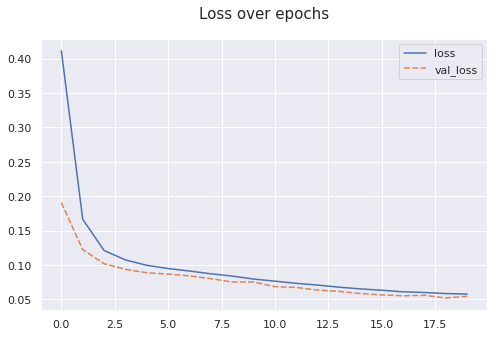

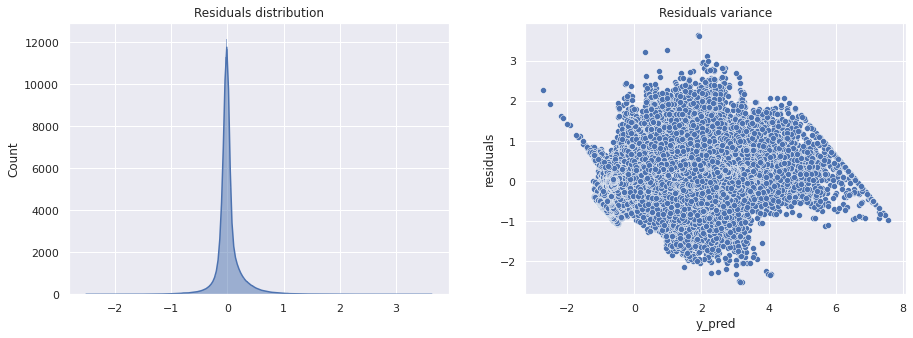

The training time of the model has been:  207.65954160690308  seconds.


In [ ]:
# Model 9.2 (Bidirectional LSTM)

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=3, monitor='loss')

t1 = time()
model9_2 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), input_shape=(80,5)),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(80)
])
model9_2.compile(loss='mean_squared_error', optimizer='adam')
print(model9_2.summary())
history = model9_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 20, batch_size = 512, verbose=0, callbacks=[callback]) # We encrease epochs because there are more parameters
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

performance_metrics(y_train.flatten(), model9_2.predict(X_train).flatten(), data='Training', all_metrics=False)
performance_metrics(y_val.flatten(), model9_2.predict(X_val).flatten())

print('The training time of the model has been: ', t2-t1, ' seconds.') 

The results of these last model are the best ones until now.

#### Model 10 CNN

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 73, 16)            656       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 36, 16)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 29, 32)            4128      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 14, 32)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 7, 64)             16448     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 192)             

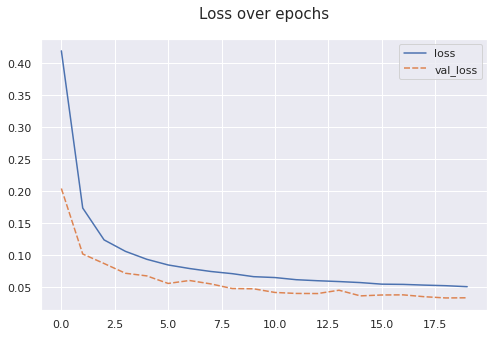

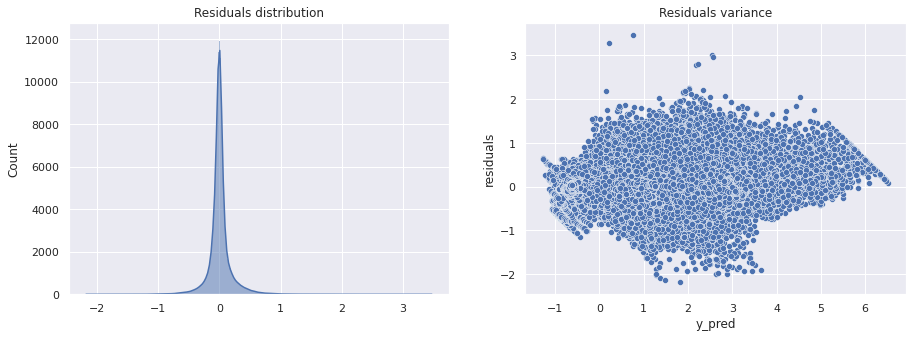

The training time of the model has been:  84.54925394058228  seconds.


In [ ]:
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=3, monitor='loss')

t1 = time()
model10 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=8, input_shape=(80,5)),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Conv1D(filters=32, kernel_size=8),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Conv1D(filters=64, kernel_size=8),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(80)                                                           
])
model10.compile(loss='mean_squared_error', optimizer='adam')
model10.summary()

history = model10.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 20, batch_size = 512, verbose=0, callbacks=[callback]) # We encrease epochs because there are more parameters
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

performance_metrics(y_train.flatten(), model10.predict(X_train).flatten(), data='Training', all_metrics=False)
performance_metrics(y_val.flatten(), model10.predict(X_val).flatten())

print('The training time of the model has been: ', t2-t1, ' seconds.') 


## Optimization of the best Models

In this section we will try to optimize the best models: Model 8.1 (Simple RNN returning sequences), Model 9.2 (Bidirectional LSTM + Dense Layers) and Model 10 (Convolutional 1D). <br>
The models have performed very well with a very small number of params, and they looked underfitted, so we will try to increase the conplexity of the models by adding layers and units.

In [ ]:
# The best models are the sequential deep learning models, so the preprocessing will be the same

# Separating X and y

X = train.drop(['pressure', 'id', 'breath_id', 'pressure_standarized'], axis=1)
y = train['pressure_standarized']

# Data scaling: MinMax scalerh 

from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Reshaping: The train data is perfectly ordered by breath_id and time_step, and there are 80 rows per breath, so we only need to use the reshape function

X = X_scaled.values.reshape((75450,80,5))
y = y.values.reshape((75450,80,1))

# Separating train, validation and test splits

from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state = 42, test_size = 0.2)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_val.shape: ', X_val.shape)
print('y_val.shape: ', y_val.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

#### Simple RNN returning sequences

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_22 (SimpleRNN)    (None, 80, 128)           17152     
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, 80, 256)           98560     
_________________________________________________________________
simple_rnn_24 (SimpleRNN)    (None, 80, 64)            20544     
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, 80, 1)             66        
Total params: 136,322
Trainable params: 136,322
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
95/95 [==============================] - 42s 411ms/step - loss: 0.3259 - val_loss: 0.2425
Epoch 2/20
95/95 [==============================] - 37s 395ms/step - loss: 0.1990 - val_loss: 0.1620
Epoch 3/20
95/95 [====================

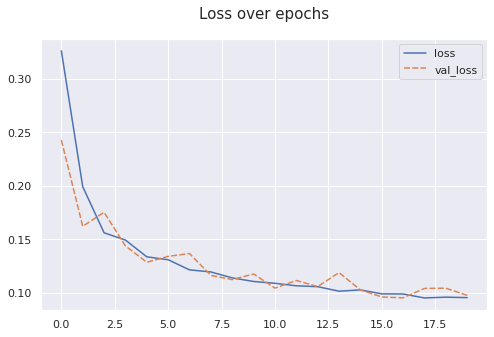

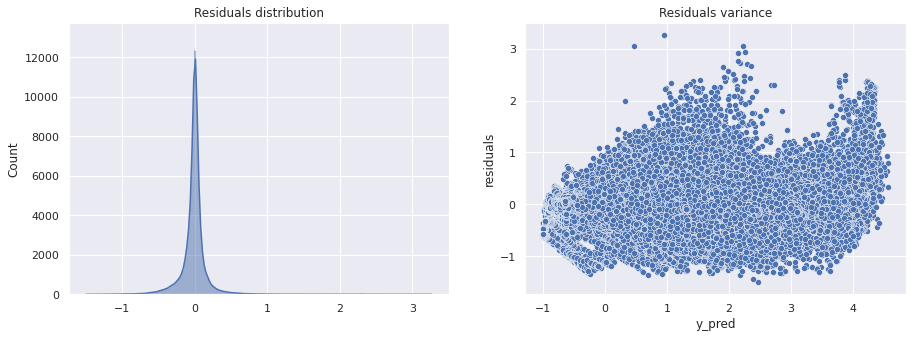

The training time of the model has been:  804.9378733634949  seconds.


In [ ]:
# Model 8.1 Optimization 

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=5, monitor='loss', restore_best_weights=True)

t1 = time()
model8_1 = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(128, return_sequences=True, input_shape=(80,5)),
  tf.keras.layers.SimpleRNN(256, return_sequences=True),
  tf.keras.layers.SimpleRNN(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(1, return_sequences=True, activation='linear')
])
model8_1.compile(loss='mae', optimizer='adam')
print(model8_1.summary())
history = model8_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 20, batch_size = 512, verbose=1, callbacks=[callback]) # We will train this model only for 20 epochs, because RNNs are very expensive to train
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

performance_metrics(y_train.flatten(), model8_1.predict(X_train).flatten(), data='Training', all_metrics=False)
performance_metrics(y_val.flatten(), model8_1.predict(X_val).flatten())

print('The training time of the model has been: ', t2-t1, ' seconds.') 

#### Bidirectional LSTM + Dense layers

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 80, 128)           35840     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 80, 256)           263168    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)              

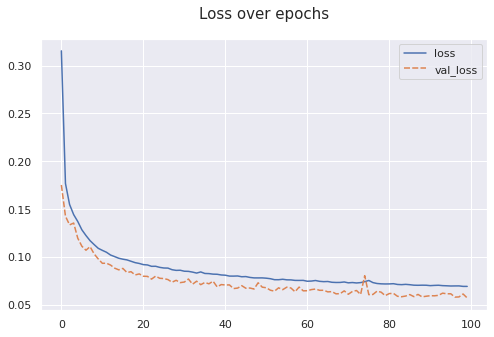

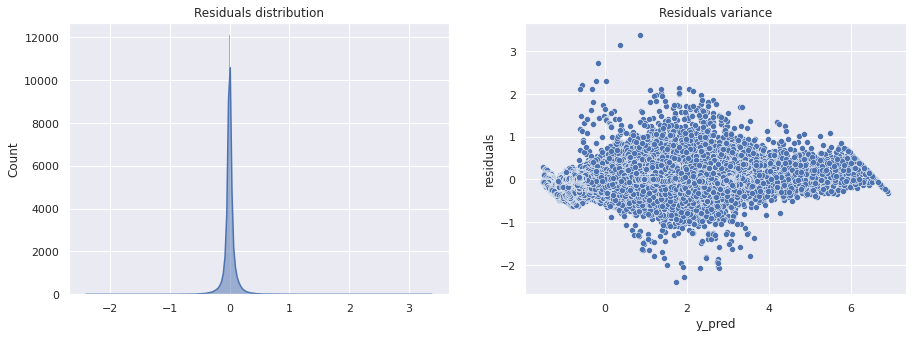

The training time of the model has been:  2313.8181936740875  seconds.


In [ ]:
# Model 9.2 (Bidirectional LSTM) optimization 1

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=5, monitor='loss', restore_best_weights=True)

t1 = time()
model9_2 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), input_shape=(80,5)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(80)
])
model9_2.compile(loss='mae', optimizer='adam')
print(model9_2.summary())
history = model9_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 100, batch_size = 512, verbose=1, callbacks=[callback]) 
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

performance_metrics(y_train.flatten(), model9_2.predict(X_train).flatten(), data='Training', all_metrics=False)
performance_metrics(y_val.flatten(), model9_2.predict(X_val).flatten())

print('The training time of the model has been: ', t2-t1, ' seconds.') 

#### Convolutional 1D

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 73, 128)           5248      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 36, 128)           0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 33, 256)           131328    
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 16, 256)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 15, 512)           262656    
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 7, 512)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 6, 1024)         

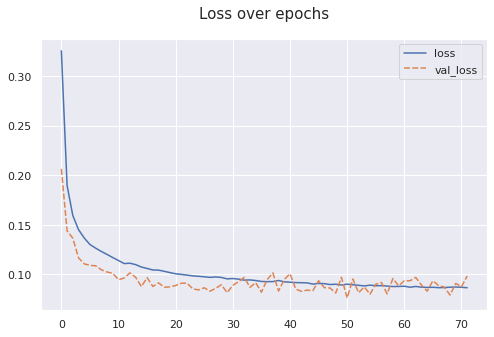

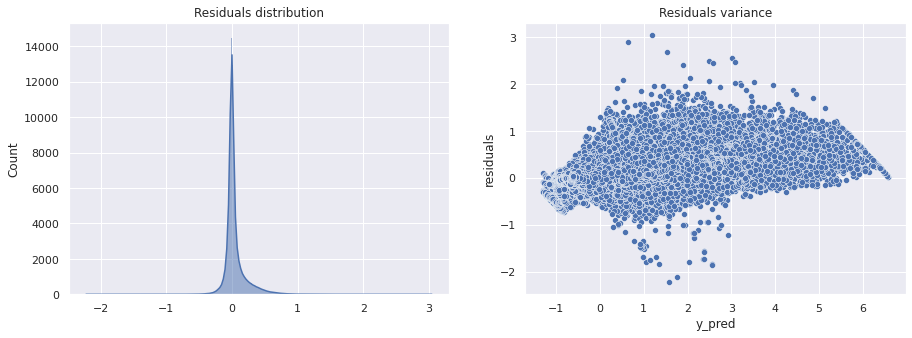

The training time of the model has been:  576.7403419017792  seconds.


In [ ]:
# Model 10 optimization

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=5, monitor='loss', restore_best_weights=True)

t1 = time()
model10 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=8, input_shape=(80,5)),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Conv1D(filters=256, kernel_size=4),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Conv1D(filters=512, kernel_size=2),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Conv1D(filters=1024, kernel_size=2),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(80)                                                           
])
model10.compile(loss='mae', optimizer='adam')
model10.summary()

history = model10.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 100, batch_size = 512, verbose=1, callbacks=[callback])
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

performance_metrics(y_train.flatten(), model10.predict(X_train).flatten(), data='Training', all_metrics=False)
performance_metrics(y_val.flatten(), model10.predict(X_val).flatten())

print('The training time of the model has been: ', t2-t1, ' seconds.') 

# Testing the models

Next we will test the models with the test samples. Remember that we standarized the target feature, so in order to have the most accurated evaluation of the model we will inverse transform the target feature before calculating MAE.


Metrics in the  Test  set:

Mean squared error:  1.987431277860222
Mean absolute error:  0.7819962623107646
R2 score:  0.9696839934119694
Max error:  48.2936308225018
Explained variance score:  0.969769364033003


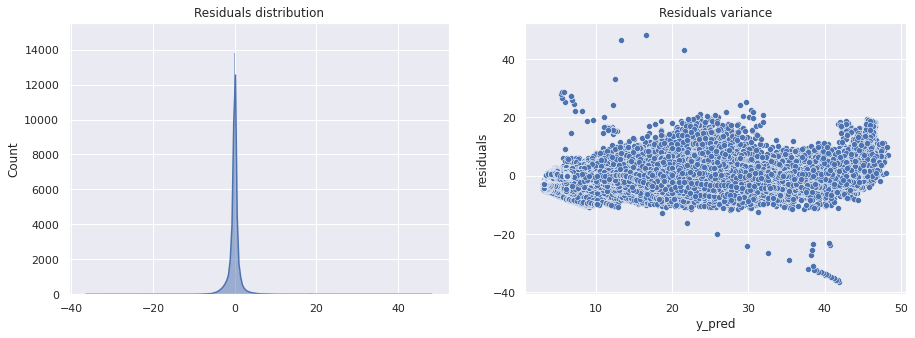

In [ ]:
# Model 8.1 test

y = stscaler.inverse_transform(y_test.flatten())
y_pred = stscaler.inverse_transform(model8_1.predict(X_test).flatten())

performance_metrics(y, y_pred, data='Test')


Metrics in the  Test  set:

Mean squared error:  0.6713796882509863
Mean absolute error:  0.4562261580480804
R2 score:  0.989758865486911
Max error:  52.47740672429623
Explained variance score:  0.9897656762014398


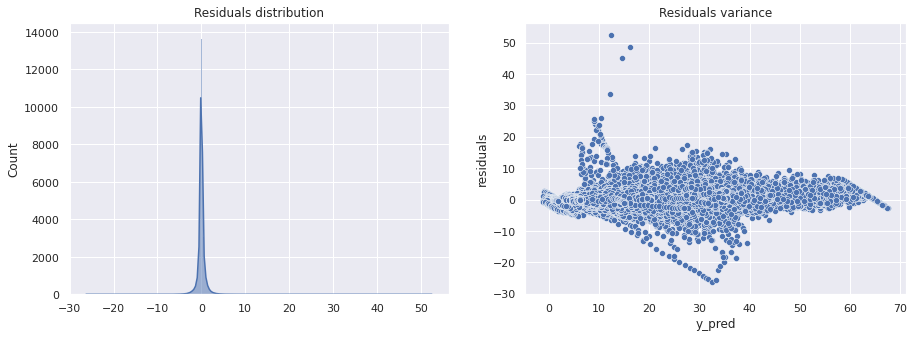

In [ ]:
# Model 9.2 test

y = stscaler.inverse_transform(y_test.flatten())
y_pred = stscaler.inverse_transform(model9_2.predict(X_test).flatten())

performance_metrics(y, y_pred, data='Test')


Metrics in the  Test  set:

Mean squared error:  1.6700832234772807
Mean absolute error:  0.7126471137492747
R2 score:  0.9745247775007305
Max error:  51.70094416936459
Explained variance score:  0.9764663704339132


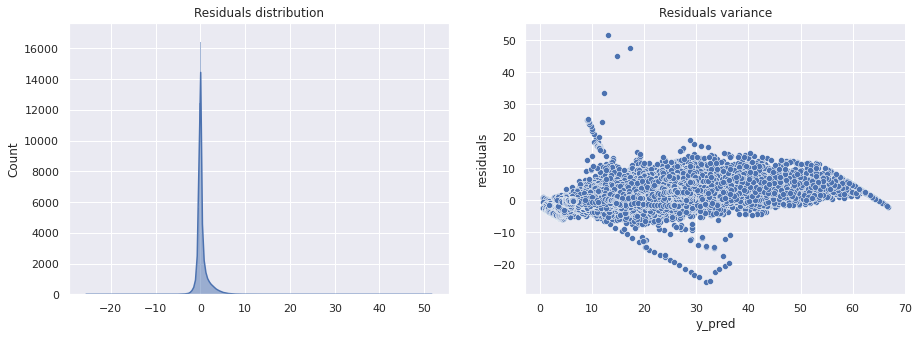

In [ ]:
# Model 10 test

y = stscaler.inverse_transform(y_test.flatten())
y_pred = stscaler.inverse_transform(model10.predict(X_test).flatten())

performance_metrics(y, y_pred, data='Test')

# Exporting submission files

### Importing the sample submission and the test set

In [ ]:
# Import test set

test = pd.read_csv('/content/drive/MyDrive/DS/Ventilator Pressure Prediction/test.csv')
test

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0
...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1
4023996,4023997,125748,20,10,2.563853,4.975709,1
4023997,4023998,125748,20,10,2.597475,4.979468,1
4023998,4023999,125748,20,10,2.631134,4.982648,1


In [ ]:
# Import sample submission

sample_submission = pd.read_csv('/content/drive/MyDrive/DS/Ventilator Pressure Prediction/sample_submission.csv')
sample_submission

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
4023995,4023996,0
4023996,4023997,0
4023997,4023998,0
4023998,4023999,0


### Training the models with the full train dataset

In [ ]:
# Preprocessing

# Separating X and y

X = train.drop(['pressure', 'id', 'breath_id', 'pressure_standarized'], axis=1)
y = train['pressure_standarized']

# Data scaling: MinMax scaler

from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Reshaping: The train data is perfectly ordered by breath_id and time_step, and there are 80 rows per breath, so we only need to use the reshape function

X = X_scaled.values.reshape((75450,80,5))
y = y.values.reshape((75450,80,1))

print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

X.shape:  (75450, 80, 5)
y.shape:  (75450, 80, 1)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 80, 128)           17152     
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 80, 256)           98560     
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 80, 64)            20544     
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 80, 1)             66        
Total params: 136,322
Trainable params: 136,322
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
148/148 [==============================] - 66s 431ms/step - loss: 2.3144
Epoch 2/20
148/148 [==============================] - 63s 425ms/step - loss: 0.4878
Epoch 3/20
148/148 [==============================] - 63s 428ms/step - lo

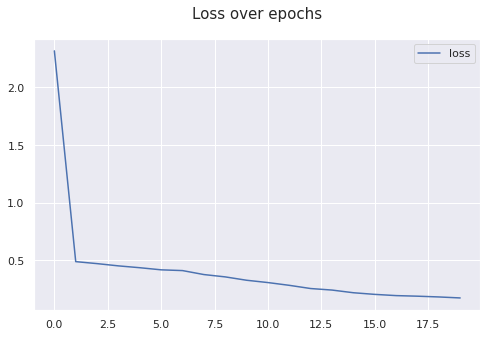

In [ ]:
# Training the model 8.1 

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=5, monitor='loss', restore_best_weights=True)

t1 = time()
model8_1 = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(128, return_sequences=True, input_shape=(80,5)),
  tf.keras.layers.SimpleRNN(256, return_sequences=True),
  tf.keras.layers.SimpleRNN(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(1, return_sequences=True, activation='linear')
])
model8_1.compile(loss='mae', optimizer='adam')
print(model8_1.summary())
history = model8_1.fit(X, y, epochs = 20, batch_size = 512, verbose=1, callbacks=[callback])
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

print('The training time of the model has been: ', t2-t1, ' seconds.')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 80, 128)           35840     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 256)           263168    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

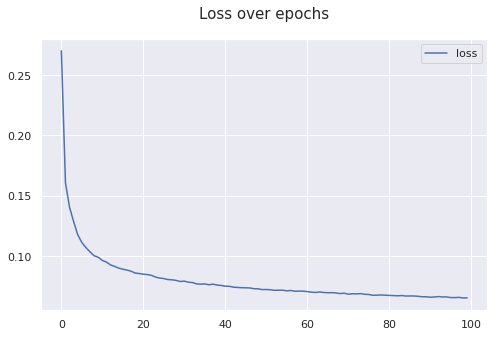

In [ ]:
# Training the model 9.2

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=5, monitor='loss', restore_best_weights=True)

t1 = time()
model9_2 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), input_shape=(80,5)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(80)
])
model9_2.compile(loss='mae', optimizer='adam')
print(model9_2.summary())
history = model9_2.fit(X, y, epochs = 100, batch_size = 512, verbose=1, callbacks=[callback])   
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

print('The training time of the model has been: ', t2-t1, ' seconds.') 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 73, 128)           5248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 36, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 256)           131328    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 512)           262656    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 512)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 1024)          

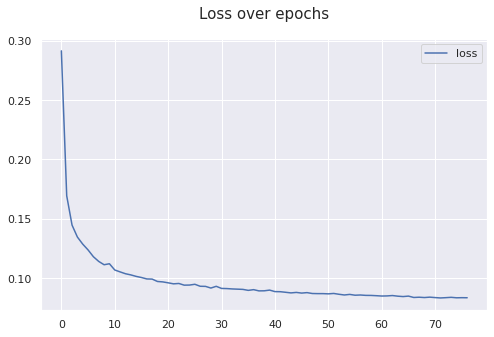

In [ ]:
# Training the model 10

import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=5, monitor='loss', restore_best_weights=True)

t1 = time()
model10 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=8, input_shape=(80,5)),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Conv1D(filters=256, kernel_size=4),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Conv1D(filters=512, kernel_size=2),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Conv1D(filters=1024, kernel_size=2),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(80)                                                           
])
model10.compile(loss='mae', optimizer='adam')
model10.summary()

history = model10.fit(X, y, epochs = 100, batch_size = 512, verbose=1, callbacks=[callback]) 
t2 = time()

plt.figure(figsize=(8,5))
lineplot = sns.lineplot(data=history.history)
lineplot.set_title('Loss over epochs', fontdict={'fontsize':15}, pad=20) 

print('The training time of the model has been: ', t2-t1, ' seconds.') 

### Saving models with pickle

In [ ]:
# import module

import pickle

# get weights

weights8_1 = model8_1.get_weights()
weights9_2 = model9_2.get_weights()
weights10 = model10.get_weights()

# Dump the model

with open('/content/drive/MyDrive/DS/Ventilator Pressure Prediction/model8_1.pickle','wb') as modelFile:
     pickle.dump(weights8_1,modelFile)
with open('/content/drive/MyDrive/DS/Ventilator Pressure Prediction/model9_2.pickle','wb') as modelFile:
     pickle.dump(weights9_2,modelFile)
with open('/content/drive/MyDrive/DS/Ventilator Pressure Prediction/model10.pickle','wb') as modelFile:
     pickle.dump(weights10,modelFile)

In [ ]:
#import module

import pickle

#Load the model - No need to TRAIN it again

with open('/content/drive/MyDrive/DS/Ventilator Pressure Prediction/model8_1.pickle','rb') as modelFile:
     weights8_1 = pickle.load(modelFile)
with open('/content/drive/MyDrive/DS/Ventilator Pressure Prediction/model9_2.pickle','rb') as modelFile:
     weights9_2 = pickle.load(modelFile)
with open('/content/drive/MyDrive/DS/Ventilator Pressure Prediction/model10.pickle','rb') as modelFile:
     weights10 = pickle.load(modelFile)

### Making predictions

In [ ]:
# Preprocessing test data

X_test = test.drop(['id', 'breath_id'], axis=1)

X_test = minmax_scaler.transform(X_test)

X_test = X_test.reshape((50300,80,5))

In [ ]:
# Making predictions

model8_1_predictions = stscaler.inverse_transform(model8_1.predict(X_test).flatten())

model9_2_predictions = stscaler.inverse_transform(model9_2.predict(X_test).flatten())

model10_predictions = stscaler.inverse_transform(model10.predict(X_test).flatten())

In [ ]:
# Concatenating predictions with id

predictions8_1 = pd.concat([test.id, pd.Series(model8_1_predictions)], axis=1)
predictions8_1.columns = ['id', 'prediction']

predictions9_2 = pd.concat([test.id, pd.Series(model9_2_predictions)], axis=1)
predictions9_2.columns = ['id', 'prediction']

predictions10 = pd.concat([test.id, pd.Series(model10_predictions)], axis=1)
predictions10.columns = ['id', 'prediction']

In [ ]:
# Exporting csv files

predictions8_1.to_csv(r'/content/drive/MyDrive/DS/Ventilator Pressure Prediction/predictions8_1.csv', index = False)

predictions9_2.to_csv(r'/content/drive/MyDrive/DS/Ventilator Pressure Prediction/predictions9_2.csv', index = False)

predictions10.to_csv(r'/content/drive/MyDrive/DS/Ventilator Pressure Prediction/predictions10.csv', index = False)